# Designing a Protein to Bind with Epidermal Growth Factor Receptor (EGFR) for Adaptyv Bio Protein Design Competition
This notebook follows the process of creating proteins using RFdiffision and  analyzing performance using ESM-2 to calculate Masked Language Model (MLM) loss.

In [ ]:
#@title setup **RFdiffusion** (~3min)
%%time
import os, time, signal
import sys, random, string, re
if not os.path.isdir("params"):
  os.system("apt-get install aria2")
  os.system("mkdir params")
  # send param download into background
  os.system("(\
  aria2c -q -x 16 https://files.ipd.uw.edu/krypton/schedules.zip; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; \
  touch params/done.txt) &")

if not os.path.isdir("RFdiffusion"):
  print("installing RFdiffusion...")
  os.system("git clone https://github.com/sokrypton/RFdiffusion.git")
  os.system("pip install jedi omegaconf hydra-core icecream pyrsistent pynvml decorator")
  os.system("pip install git+https://github.com/NVIDIA/dllogger#egg=dllogger")
  # 17Mar2024: adding --no-dependencies to avoid installing nvidia-cuda-* dependencies
  os.system("pip install --no-dependencies dgl==2.0.0 -f https://data.dgl.ai/wheels/cu121/repo.html")
  os.system("pip install --no-dependencies e3nn==0.3.3 opt_einsum_fx")
  os.system("cd RFdiffusion/env/SE3Transformer; pip install .")
  os.system("wget -qnc https://files.ipd.uw.edu/krypton/ananas")
  os.system("chmod +x ananas")

if not os.path.isdir("colabdesign"):
  print("installing ColabDesign...")
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

if not os.path.isdir("RFdiffusion/models"):
  print("downloading RFdiffusion params...")
  os.system("mkdir RFdiffusion/models")
  models = ["Base_ckpt.pt","Complex_base_ckpt.pt"]
  for m in models:
    while os.path.isfile(f"{m}.aria2"):
      time.sleep(5)
  os.system(f"mv {' '.join(models)} RFdiffusion/models")
  os.system("unzip schedules.zip; rm schedules.zip")

if 'RFdiffusion' not in sys.path:
  os.environ["DGLBACKEND"] = "pytorch"
  sys.path.append('RFdiffusion')

from google.colab import files
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

def get_pdb(pdb_code=None):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    if not os.path.isfile(f"{pdb_code}.pdb1"):
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
      os.system(f"gunzip {pdb_code}.pdb1.gz")
    return f"{pdb_code}.pdb1"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

def run_ananas(pdb_str, path, sym=None):
  pdb_filename = f"outputs/{path}/ananas_input.pdb"
  out_filename = f"outputs/{path}/ananas.json"
  with open(pdb_filename,"w") as handle:
    handle.write(pdb_str)

  cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
  if sym is None: os.system(cmd)
  else: os.system(f"{cmd} {sym}")

  # parse results
  try:
    out = json.loads(open(out_filename,"r").read())
    results,AU = out[0], out[-1]["AU"]
    group = AU["group"]
    chains = AU["chain names"]
    rmsd = results["Average_RMSD"]
    print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")

    C = np.array(results['transforms'][0]['CENTER'])
    A = [np.array(t["AXIS"]) for t in results['transforms']]

    # apply symmetry and filter to the asymmetric unit
    new_lines = []
    for line in pdb_str.split("\n"):
      if line.startswith("ATOM"):
        chain = line[21:22]
        if chain in chains:
          x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
          if group[0] == "c":
            x = sym_it(x,C,A[0])
          if group[0] == "d":
            x = sym_it(x,C,A[1],A[0])
          coord_str = "".join(["{:8.3f}".format(a) for a in x])
          new_lines.append(line[:30]+coord_str+line[54:])
      else:
        new_lines.append(line)
    return results, "\n".join(new_lines)

  except:
    return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):

  def run_command_and_get_pid(command):
    pid_file = '/dev/shm/pid'
    os.system(f'nohup {command} > /dev/null & echo $! > {pid_file}')
    with open(pid_file, 'r') as f:
      pid = int(f.read().strip())
    os.remove(pid_file)
    return pid
  def is_process_running(pid):
    try:
      os.kill(pid, 0)
    except OSError:
      return False
    else:
      return True

  run_output = widgets.Output()
  progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
  display(widgets.VBox([progress, run_output]))

  # clear previous run
  for n in range(steps):
    if os.path.isfile(f"/dev/shm/{n}.pdb"):
      os.remove(f"/dev/shm/{n}.pdb")

  pid = run_command_and_get_pid(command)
  try:
    fail = False
    for _ in range(num_designs):

      # for each step check if output generated
      for n in range(steps):
        wait = True
        while wait and not fail:
          time.sleep(0.1)
          if os.path.isfile(f"/dev/shm/{n}.pdb"):
            pdb_str = open(f"/dev/shm/{n}.pdb").read()
            if pdb_str[-3:] == "TER":
              wait = False
            elif not is_process_running(pid):
              fail = True
          elif not is_process_running(pid):
            fail = True

        if fail:
          progress.bar_style = 'danger'
          progress.description = "failed"
          break

        else:
          progress.value = (n+1) / steps
          if visual != "none":
            with run_output:
              run_output.clear_output(wait=True)
              if visual == "image":
                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                fig = plt.figure()
                fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1)
                plt.show()
              if visual == "interactive":
                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                view.addModel(pdb_str,'pdb')
                view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                view.zoomTo()
                view.show()
        if os.path.exists(f"/dev/shm/{n}.pdb"):
          os.remove(f"/dev/shm/{n}.pdb")
      if fail:
        progress.bar_style = 'danger'
        progress.description = "failed"
        break

    while is_process_running(pid):
      time.sleep(0.1)

  except KeyboardInterrupt:
    os.kill(pid, signal.SIGTERM)
    progress.bar_style = 'danger'
    progress.description = "stopped"

def run_diffusion(contigs, path, pdb=None, iterations=50,
                  symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False,
                  num_designs=1, visual="none"):

  full_path = f"outputs/{path}"
  os.makedirs(full_path, exist_ok=True)
  opts = [f"inference.output_prefix={full_path}",
          f"inference.num_designs={num_designs}"]

  if chains == "": chains = None

  # determine symmetry type
  if symmetry in ["auto","cyclic","dihedral"]:
    if symmetry == "auto":
      sym, copies = None, 1
    else:
      sym, copies = {"cyclic":(f"c{order}",order),
                     "dihedral":(f"d{order}",order*2)}[symmetry]
  else:
    symmetry = None
    sym, copies = None, 1

  # determine mode
  contigs = contigs.replace(","," ").replace(":"," ").split()
  is_fixed, is_free = False, False
  fixed_chains = []
  for contig in contigs:
    for x in contig.split("/"):
      a = x.split("-")[0]
      if a[0].isalpha():
        is_fixed = True
        if a[0] not in fixed_chains:
          fixed_chains.append(a[0])
      if a.isnumeric():
        is_free = True
  if len(contigs) == 0 or not is_free:
    mode = "partial"
  elif is_fixed:
    mode = "fixed"
  else:
    mode = "free"

  # fix input contigs
  if mode in ["partial","fixed"]:
    pdb_str = pdb_to_string(get_pdb(pdb), chains=chains)
    if symmetry == "auto":
      a, pdb_str = run_ananas(pdb_str, path)
      if a is None:
        print(f'ERROR: no symmetry detected')
        symmetry = None
        sym, copies = None, 1
      else:
        if a["group"][0] == "c":
          symmetry = "cyclic"
          sym, copies = a["group"], int(a["group"][1:])
        elif a["group"][0] == "d":
          symmetry = "dihedral"
          sym, copies = a["group"], 2 * int(a["group"][1:])
        else:
          print(f'ERROR: the detected symmetry ({a["group"]}) not currently supported')
          symmetry = None
          sym, copies = None, 1

    elif mode == "fixed":
      pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)

    pdb_filename = f"{full_path}/input.pdb"
    with open(pdb_filename, "w") as handle:
      handle.write(pdb_str)

    parsed_pdb = parse_pdb(pdb_filename)
    opts.append(f"inference.input_pdb={pdb_filename}")
    if mode in ["partial"]:
      iterations = int(80 * (iterations / 200))
      opts.append(f"diffuser.partial_T={iterations}")
      contigs = fix_partial_contigs(contigs, parsed_pdb)
    else:
      opts.append(f"diffuser.T={iterations}")
      contigs = fix_contigs(contigs, parsed_pdb)
  else:
    opts.append(f"diffuser.T={iterations}")
    parsed_pdb = None
    contigs = fix_contigs(contigs, parsed_pdb)

  if hotspot is not None and hotspot != "":
    opts.append(f"ppi.hotspot_res=[{hotspot}]")

  # setup symmetry
  if sym is not None:
    sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
    if add_potential:
      sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'",
                   "potentials.olig_intra_all=True","potentials.olig_inter_all=True",
                   "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
    opts = sym_opts + opts
    contigs = sum([contigs] * copies,[])

  opts.append(f"'contigmap.contigs=[{' '.join(contigs)}]'")
  opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]

  print("mode:", mode)
  print("output:", full_path)
  print("contigs:", contigs)

  opts_str = " ".join(opts)
  cmd = f"./RFdiffusion/run_inference.py {opts_str}"
  print(cmd)

  # RUN
  run(cmd, iterations, num_designs, visual=visual)

  # fix pdbs
  for n in range(num_designs):
    pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb",
            f"outputs/traj/{path}_{n}_Xt-1_traj.pdb",
            f"{full_path}_{n}.pdb"]
    for pdb in pdbs:
      with open(pdb,"r") as handle: pdb_str = handle.read()
      with open(pdb,"w") as handle: handle.write(fix_pdb(pdb_str, contigs))

  return contigs, copies

installing RFdiffusion...
installing ColabDesign...
downloading RFdiffusion params...


/usr/local/lib/python3.10/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.d

CPU times: user 6.98 s, sys: 821 ms, total: 7.8 s
Wall time: 2min 33s


The settings used below will create 8 proteins through 50 iterations of RFdiffusion designed to bind with EGFR (6ARU). The designs will be targeted towards the hotspots listed under the "hotspots" input box.

In [ ]:
%%time
#@title run **RFdiffusion** to generate a backbone
name = "EGFR" #@param {type:"string"}
contigs = "100-200" #@param {type:"string"}
pdb = "6ARU" #@param {type:"string"}
iterations = 50 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = "A11,A12,A13,A15,A16,A17,A18,A356" #@param {type:"string"}
num_designs = 8 #@param ["1", "2", "4", "8", "16", "32"] {type:"raw"}
visual = "image" #@param ["none", "image", "interactive"]
#@markdown ---
#@markdown **symmetry** settings
#@markdown ---
symmetry = "none" #@param ["none", "auto", "cyclic", "dihedral"]
order = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
chains = "" #@param {type:"string"}
add_potential = True #@param {type:"boolean"}
#@markdown - `symmetry='auto'` enables automatic symmetry dectection with [AnAnaS](https://team.inria.fr/nano-d/software/ananas/).
#@markdown - `chains="A,B"` filter PDB input to these chains (may help auto-symm detector)
#@markdown - `add_potential` to discourage clashes between chains

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "visual":visual}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')

contigs, copies = run_diffusion(**flags)

mode: free
output: outputs/EGFR
contigs: ['200-200']
./RFdiffusion/run_inference.py inference.output_prefix=outputs/EGFR inference.num_designs=8 diffuser.T=50 ppi.hotspot_res=[A11,A12,A13,A15,A16,A17,A18,A356] 'contigmap.contigs=[200-200]' inference.dump_pdb=True inference.dump_pdb_path='/dev/shm'


CPU times: user 2min 33s, sys: 23.9 s, total: 2min 57s
Wall time: 14min 33s


In [ ]:
%%time
#@title run **ProteinMPNN** to generate a sequence and **AlphaFold** to validate
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
initial_guess = False #@param {type:"boolean"}
num_recycles = 1 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = False #@param {type:"boolean"}
rm_aa = "C" #@param {type:"string"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
#@markdown - for **binder** design, we recommend `initial_guess=True num_recycles=3`

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if initial_guess: opts.append("--initial_guess")
if use_multimer: opts.append("--use_multimer")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

{'pdb':'outputs/EGFR_0.pdb','loc':'outputs/EGFR','contigs':'200-200','copies':1,'num_seqs':8,'initial_guess':False,'use_multimer':False,'num_recycles':1,'rm_aa':'C','num_designs':8,'mpnn_sampling_temp':0.1}
protocol=fixbb
2024-10-31 15:50:25.900478: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
running proteinMPNN...
running AlphaFold...
design:0 n:0 mpnn:1.008 plddt:0.918 ptm:0.760 pae:5.747 rmsd:1.183 SAAERERAEREARIEALKAEIAALAAEAAALAAELARQQERLAFVDDFLAKLEELEKKLEEAKKLAEEAIKTGSEELLKKAKEKAKKVLEELKAFLKETKAKLEALAKSGLTEEAKAVEKEVTAKLEEIIKKVEKAIKAKEPEEAKKLLEEALKLLKELREWLEKEVRGGTEARIAALQARIAALAARRAELEAELAALE
design:0 n:1 mpnn:1.088 plddt:0.915 ptm:0.721 pae:6.722 r

In [ ]:
#@title Display best result
import py3Dmol
def plot_pdb(num = "best"):
  if num == "best":
    with open(f"outputs/{path}/best.pdb","r") as f:
      # REMARK 001 design {m} N {n} RMSD {rmsd}
      info = f.readline().strip('\n').split()
    num = info[3]
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(f"outputs/{path}_{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  pdb_str = open(f"outputs/{path}/best_design{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

  view.setStyle({"model":0},{'cartoon':{}}) #: {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.setStyle({"model":1},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.zoomTo()
  view.show()

if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive,
#@markdown try disabling your adblocker and run this cell again.
#@markdown  If that fails click on the little folder icon to the
#@markdown  left, navigate to file: `name.result.zip`,
#@markdown  right-click and select \"Download\"
#@markdown (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).
!zip -r {path}.result.zip outputs/{path}* outputs/traj/{path}*
files.download(f"{path}.result.zip")

  adding: outputs/EGFR/ (stored 0%)
  adding: outputs/EGFR/mpnn_results.csv (deflated 52%)
  adding: outputs/EGFR/all_pdb/ (stored 0%)
  adding: outputs/EGFR/all_pdb/design3_n5.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design4_n3.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design7_n2.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design2_n6.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design1_n2.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design7_n7.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design5_n4.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design6_n1.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design3_n4.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design7_n5.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design0_n4.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design1_n6.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design5_n1.pdb (deflated 78%)
  adding: outputs/EGFR/all_pdb/design6_n7.pdb (deflated 78%)
  adding: o

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Validating and ranking further with MLM loss calculated by ESM-2
Loading results for ESM-2 testing.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import pandas as pd

# File output from above was moved into google drive project folder
output_path = '/content/drive/My Drive/Mini-Project2/EGFR.result/outputs/EGFR/mpnn_results.csv'

potential_binders = []  # A list to store sequences

designs = pd.read_csv(output_path)

for design in designs['seq']:
  potential_binders.append(design)


In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch

# Load the base model and tokenizer
base_model_path = "facebook/esm2_t12_35M_UR50D"
model = AutoModelForMaskedLM.from_pretrained(base_model_path)
tokenizer = AutoTokenizer.from_pretrained(base_model_path)

# Ensure the model is in evaluation mode
model.eval()

# Define the protein of interest and its potential binders
protein_of_interest = "LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPS"

def compute_mlm_loss(protein, binder, iterations=3):
    total_loss = 0.0

    for _ in range(iterations):
        # Concatenate protein sequences with a separator
        concatenated_sequence = protein + ":" + binder

        # Mask a subset of amino acids in the concatenated sequence (excluding the separator)
        tokens = list(concatenated_sequence)
        mask_rate = 0.15  # For instance, masking 15% of the sequence
        num_mask = int(len(tokens) * mask_rate)

        # Exclude the separator from potential mask indices
        available_indices = [i for i, token in enumerate(tokens) if token != ":"]
        probs = torch.ones(len(available_indices))
        mask_indices = torch.multinomial(probs, num_mask, replacement=False)

        for idx in mask_indices:
            tokens[available_indices[idx]] = tokenizer.mask_token

        masked_sequence = "".join(tokens)
        inputs = tokenizer(masked_sequence, return_tensors="pt", truncation=True, max_length=1024, padding='max_length')

        # Compute the MLM loss
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss

        total_loss += loss.item()

    # Return the average loss
    return total_loss / iterations

# Compute MLM loss for each potential binder
mlm_losses = {}
for binder in potential_binders:
    loss = compute_mlm_loss(protein_of_interest, binder)
    mlm_losses[binder] = loss

# Rank binders based on MLM loss
ranked_binders = sorted(mlm_losses, key=mlm_losses.get)

print("Ranking of Potential Binders:")
for idx, binder in enumerate(ranked_binders, 1):
    print(f"{idx}. {binder} - MLM Loss: {mlm_losses[binder]}")


Ranking of Potential Binders:
1. SLLEELAEKEEEEEEEEEEEEEEEEEEEEEEEEEKRREEEEKKKKEELEKIKKETKEKLKELLEEAKKLIKKIEELLKNIDTVKDEEIEELIKELKRLAEKLKELAALLEKFKEYEELVKLVKEAEEKVKKLAEALEKYKKDKTEESKKEFIKKAKEALKKLKELIKKIEELLKKEEEAKKEEEAKLAAAKAALAALLAA - MLM Loss: 7.32786210378011
2. MEEREKLEKEVAKLKKEIDAKEKEKIDKYKKRAEEIEKKYKEEVEKSKEVREEVLKELEKLIKELKEKAEKLLKEIEKGKKKEATKELIKTLKEELKKYFEKVKEKYKEAKKLAKEGELEKAVGIIVAVLEAQAKLYKVVAETLKKLLEAALKSGDLELAKETIKEVKELLKELDKLEEEVEKELEEALKAIEEEKKKKE - MLM Loss: 7.333145936330159
3. GSLKKEKEKKEKKLKEIEKEIKKLEEEKEKLKKELKLVEERLKLVEEFIKKLEELIKKLEEAVKLAKEAAKTGSEKILKEAKEKIKEVLKEAKKELEEWKKKLDELAKKGLEEEAKKLKEKLTKKMEEIIKLIEEAAKSKEAKEMIKLLEEAIKKAEETLKWLKEEVEGKLKEEKKKLEEKIKKLEEEIKKLKEEKEKLK - MLM Loss: 7.333455403645833
4. GKLEELKKKKEEKLKEIEEKIKKLEEEKEKLKKELELYKEKLELVEKLIEKLKELEKKLEEALKLAKEAAKTGSKEKLQEAKKKIKEVAKELEKAKEEFKKALEEMAKKGMTEEAKKWKEEIEKKLDEIIKKVKEAAQAKDAKEAAKLLEEAKKLLKELKEKIEKERKEELKKRIEEIEKKIKELEEEIKKLKEEKKKLE - MLM Loss: 7.334719975789388
5. SELKEKLEKLKKEEEEKKEKEKKEEEEEEEKK

# Best Design!
SLLEELAEKEEEEEEEEEEEEEEEEEEEEEEEEEKRREEEEKKKKEELEKIKKETKEKLKELLEEAKKLIKKIEELLKNIDTVKDEEIEELIKELKRLAEKLKELAALLEKFKEYEELVKLVKEAEEKVKKLAEALEKYKKDKTEESKKEFIKKAKEALKKLKELIKKIEELLKKEEEAKKEEEAKLAAAKAALAALLAA

# Visualizing
The pdb file loaded in was created by inputting the best sequence to the Alphafold2 colab notebook: https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb#scrollTo=KK7X9T44pWb7

# Generating Visual

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apbs apbs-data freeglut3 libapbs3 libevdev2 libglu1-mesa libgudev-1.0-0 libinput-bin libinput10
  libmaloc1 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5designer5 libqt5gui5 libqt5help5
  libqt5network5 libqt5opengl5 libqt5printsupport5 libqt5sql5 libqt5sql5-sqlite libqt5svg5
  libqt5test5 libqt5widgets5 libqt5xml5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4
  libxcb-image0 libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0
  libxcb-xkb1 libxkbcommon-x11-0 pymol-data python3-numpy python3-opengl python3-pymol
  python3-pyqt5 python3-pyqt5.qtopengl python3-pyqt5.sip qt5-gtk-platformtheme qttranslations5-l10n
Suggested packages:
  qt5-image-formats-plugins qtwayland5 python-numpy-doc python3-pytest libgle3
The following NEW packages will be installed:
  apbs apbs-data freeglut3 libapbs3 libevdev

Saving test_5b0a6_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb to test_5b0a6_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb


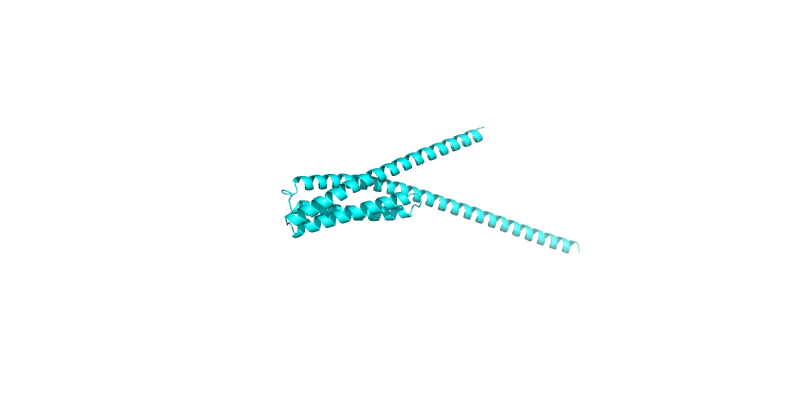

In [1]:
# Step 1: Install PyMOL
!apt-get install -y pymol

# Step 2: Upload Your PDB File
from google.colab import files

# Upload the PDB file
uploaded = files.upload()

# Step 3: Visualize the Protein Structure with PyMOL
from pymol import cmd

# Load the PDB file
pdb_filename = list(uploaded.keys())[0]  # Get the uploaded file name
cmd.load(pdb_filename)

# Visualization commands
cmd.show('cartoon')  # Show the protein in cartoon representation
cmd.color('cyan')    # Color the cartoon representation
cmd.zoom()           # Zoom into the structure

# Save the visualization as an image
cmd.png('protein_structure.png', width=800, height=400, dpi=300)

# Final Design Selection:

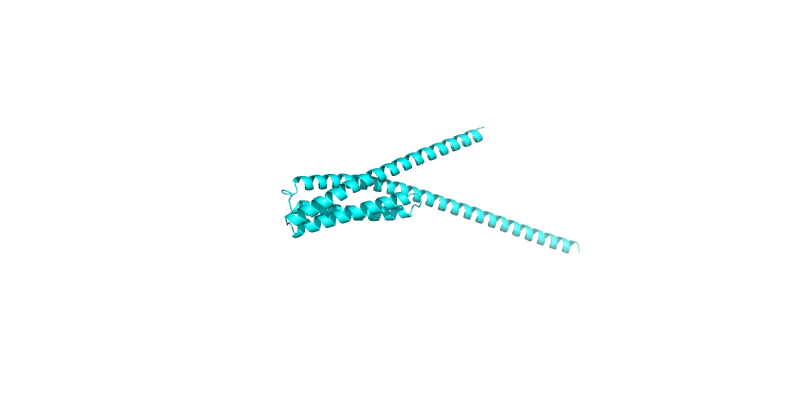

In [2]:
# Step 4: Display the Image
from IPython.display import Image

# Display the generated image
Image('protein_structure.png')

# Further Analysis:
It would be interesting to compare results from RFdiffusion to ESM-2, as I noticed there is quite a difference between top performers across the two metrics. I am not entirely experienced with the differences between how loss and performance is calculated for the two different performance analysis metrics, however a deeper understanding of why this may be the case.
